In [1]:
import os
import pytorch_lightning as pl
import torch 
from torch import nn
from torch import utils

from torchaudio import datasets, transforms
from torchvision import models

from transformers import T5Tokenizer, T5ForConditionalGeneration
import nltk
import numpy as np
import string
from pytorch_lightning.callbacks import RichProgressBar
from pytorch_lightning.loggers import NeptuneLogger
from pytorch_lightning.callbacks import ModelCheckpoint

from tqdm import tqdm


In [5]:
dataset = datasets.LIBRISPEECH(
                            root="./",
                            url="dev-clean",
                            folder_in_archive="LibriSpeech",
                            download=False
                            )

In [2]:
dataset_train = datasets.LIBRISPEECH(
                                     root="/mnt/f/train-clean-360",
                                     url="train-clean-360",
                                     folder_in_archive="LibriSpeech",
                                     download=False
                                    )

dataset_test = datasets.LIBRISPEECH(
                                    root="/mnt/f/test-clean",
                                    url="test-clean",
                                    folder_in_archive="LibriSpeech",
                                    download=False
                                    )

print(f"Tamanho do conjunto de treino: {len(dataset_train)}")
print(f"Tamanho do conjunto de teste: {len(dataset_test)}")

Tamanho do conjunto de treino: 104014
Tamanho do conjunto de teste: 2620


In [6]:
dataset_train[3]

(tensor([[ 0.0017,  0.0007, -0.0009,  ...,  0.0005,  0.0005,  0.0004]]),
 16000,
 "BUT HE WAS SO SLY AND CAUTIOUS THAT NO ONE HAD EVER CAUGHT HIM IN THE ACT OF STEALING ALTHOUGH A GOOD MANY THINGS HAD BEEN MISSED AFTER THEY HAD FALLEN INTO THE OLD MAN'S WAY BARNEY HAD ONE SON NAMED TOM",
 100,
 121669,
 3)

In [7]:
wav_lengths = []
for value in tqdm(dataset_train):
    wav_lengths.append(value[0].shape[1])

KeyboardInterrupt: 

In [10]:
len(wav_lengths)

31900

In [9]:
max(wav_lengths)

475760

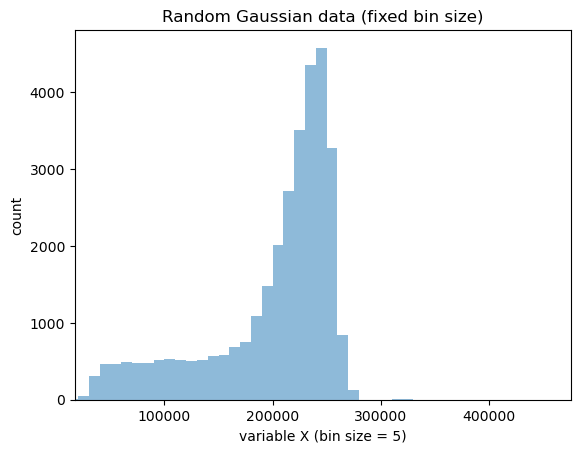

In [11]:
import numpy as np
import random
from matplotlib import pyplot as plt

data = np.array(wav_lengths)

# fixed bin size
bins = np.arange(0, 600000, 10000) # fixed bin size

plt.xlim([min(data)-5, max(data)+5])

plt.hist(data, bins=bins, alpha=0.5)
plt.title('Random Gaussian data (fixed bin size)')
plt.xlabel('variable X (bin size = 5)')
plt.ylabel('count')

plt.show()


In [3]:
encoder = models.efficientnet_b3(weights=models.EfficientNet_B3_Weights.IMAGENET1K_V1).features
decoder = T5ForConditionalGeneration.from_pretrained("t5-small")
tokenizer = T5Tokenizer.from_pretrained("t5-small")
transform = transforms.MelSpectrogram(16000, n_fft=800)

/home/dev/.local/lib/python3.9/site-packages/transformers/models/t5/tokenization_t5.py:164: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  warnings.warn(


In [6]:
class TokenizedDataset(utils.data.Dataset):
    def __init__(self, raw_dataset, tokenizer, max_len=320000):
        self.raw_dataset = raw_dataset
        self.tokenizer = tokenizer
        self.max_len = max_len
    
    def __len__(self):
        return len(self.raw_dataset)
    
    def __getitem__(self, idx):
        data = self.raw_dataset[idx]
        x = data[0]
        y = data[2]

        y = self.tokenizer.encode_plus(
                                        text=y,  # the sentence to be encoded
                                        add_special_tokens=True,  # Add [CLS] and [SEP]
                                        max_length=512,  # maximum length of a sentence
                                        padding="max_length",  # Add [PAD]s
                                        return_tensors='pt',  # ask the function to return PyTorch tensors
                                        truncation=True,
                                    )

        if x.shape[1] < self.max_len:
            pad_x = torch.zeros((x.shape[0], self.max_len))
            pad_x[:, :x.size(1)] = x
            x = pad_x
        else:
            x = x[:,0:(self.max_len)]

        
        #return x,y["input_ids"], y["attention_mask"]
        return x,y["input_ids"].squeeze(), y["attention_mask"].squeeze()

mydataset = TokenizedDataset(dataset, tokenizer)
mydataset[0][0].shape

torch.Size([1, 320000])

In [6]:
mydataset = TokenizedDataset(dataset, tokenizer)

train_set, val_set, test_set = utils.data.random_split(mydataset, [0.6, 0.2, 0.2])

train_loader = utils.data.DataLoader(train_set, batch_size=4, num_workers=os.cpu_count())
val_loader = utils.data.DataLoader(val_set, batch_size=4, num_workers=os.cpu_count())
test_set = utils.data.DataLoader(test_set, batch_size=4, num_workers=os.cpu_count())

#train_loader = utils.data.DataLoader(train_set, batch_size=2)
#val_loader = utils.data.DataLoader(val_set, batch_size=2)
#test_set = utils.data.DataLoader(test_set, batch_size=2)


In [7]:
mydataset_train = TokenizedDataset(dataset_train, tokenizer)
mydataset_test = TokenizedDataset(dataset_test, tokenizer)


train_set, val_set = utils.data.random_split(mydataset_train, [0.99, 0.01], generator=torch.Generator().manual_seed(42))

train_loader = utils.data.DataLoader(train_set, batch_size=5, shuffle=True, num_workers=os.cpu_count())
val_loader = utils.data.DataLoader(val_set, batch_size=5, num_workers=os.cpu_count())
test_loader = utils.data.DataLoader(mydataset_test, batch_size=5, num_workers=os.cpu_count())


In [8]:
class EncoderDecoder(pl.LightningModule):
    def __init__(self, encoder, decoder, transform, tokenizer):
        super().__init__()
        self.encoder = encoder
        self.decoder = decoder
        self.transform = transform
        self.tokenizer = tokenizer

        random_input = torch.rand((1,90000))
        random_spectrogram = self.transform(random_input)
        random_spectrogram = random_spectrogram.repeat(1,3,1,1)
        random_extracted_features = self.encoder(random_spectrogram)
        self.n_filters = random_extracted_features.shape[1]


    def forward(self, *args):

        x = args[0]
        out = self.transform(x)
        out = out.repeat(1, 3, 1, 1)
        out = self.encoder(out)
        out = out.permute(0, 2, 3, 1)
        out = out.reshape(-1, int(out.shape[1] * out.shape[2] * out.shape[3]/ self.decoder.config.d_model), self.decoder.config.d_model )

        if len(args) > 2:
            y = args[1]
            mask = args[2]
            out = self.decoder(inputs_embeds=out, labels=y,return_dict=True, decoder_attention_mask=mask)

        return out

    def generate(self, 
                 x,
                 mask,
                 max_length=1024,
                 min_length=0,
                 num_beams=5,
                 no_repeat_ngram_size=2,
                 num_return_sequences=1,
                 early_stopping=True,
                 decode=False):

        out = self.forward(x)
        out = self.decoder.generate(inputs_embeds=out,
                                    max_length=max_length,
                                    min_length=min_length,
                                    num_beams=num_beams, 
                                    no_repeat_ngram_size=no_repeat_ngram_size,
                                    num_return_sequences=num_return_sequences, 
                                    early_stopping=early_stopping,
                                    decoder_attention_mask=mask
                                    )
        
        if decode:
            out = self.translate_encoded_ids(out)

        return out 

    def translate_encoded_ids(self, encoded_ids_list):
        phrases = []
        for encoded_ids in encoded_ids_list:
            decoded_ids = self.tokenizer.decode(encoded_ids, skip_special_tokens=True)
            phrases.append(decoded_ids)
        return phrases

    def training_step(self, train_batch, batch_idx):
        x, y, mask = train_batch
        out  = self.forward(x, y, mask)
        loss = out.loss
        self.log("train_loss", loss)
        return loss

    def validation_step(self, val_batch, batch_idx, log=True):
        x, y, mask = val_batch
        decoded_y = self.translate_encoded_ids(y)
        
        gen_pred = self.generate(x, mask)
        decoded_gen_pred = self.translate_encoded_ids(gen_pred)

        scores = []
        for string_comb in zip(decoded_y, decoded_gen_pred):
            score = self.levensthein_distance(string_comb[0], string_comb[1])
            scores.append(score)

        scores = np.array(scores)
        batch_score = scores.mean()

        if log:
            self.log("val_levensthein", batch_score)

        return batch_score

    def test_step(self, test_batch, test_idx):
        test_score = self.validation_step(test_batch, test_idx, log=False)
        self.log("test_levensthein", test_score )
        return test_score

    def levensthein_distance(self, str_1, str_2):
        str_1 = str_1.upper()
        str_2 = str_2.upper()
        str_1 = str_1.translate(str.maketrans('','', string.punctuation))
        str_2 = str_2.translate(str.maketrans('','', string.punctuation))
        dist = (1 - nltk.edit_distance(str_2, str_1)/max(len(str_1), len(str_2)))
        return dist

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=3e-4)
        return optimizer


      




        

In [9]:
model = EncoderDecoder(encoder=encoder,
                       decoder=decoder,
                       transform=transform,
                       tokenizer=tokenizer)

batch_x, batch_y, mask = next(iter(train_loader))

gen_phrase = model.generate(batch_x, mask, decode=True)


In [9]:
model = EncoderDecoder(encoder=encoder,
                       decoder=decoder,
                       transform=transform,
                       tokenizer=tokenizer)


In [10]:
with open("neptune_key.txt", "r") as f:
    neptune_api_key = f.read()
    f.close()


In [11]:
neptune_logger = NeptuneLogger(
    api_key=neptune_api_key,  # replace with your own
    project="p175857/IA048",  # format "<WORKSPACE/PROJECT>"
    tags=["prod", "efficientnetb3"],  # optional
)

checkpoint_callback = ModelCheckpoint(dirpath="/mnt/f/IA048/BestModels", save_top_k=1, save_last=True, every_n_epochs=1, monitor="val_levensthein", mode="max", save_on_train_epoch_end=False)


In [12]:





trainer = pl.Trainer(accelerator='gpu', devices=1, callbacks=[RichProgressBar(), checkpoint_callback], logger=neptune_logger)
#trainer.fit(model, train_loader, val_loader, ckpt_path=".neptune/None/version_None/checkpoints/epoch=4-step=4055.ckpt")
trainer.fit(model, train_loader, val_loader,ckpt_path='/mnt/f/IA048/BestModels/last.ckpt')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/dev/.local/lib/python3.9/site-packages/pytorch_lightning/loops/utilities.py:94: PossibleUserWarning: `max_epochs` was not set. Setting it to 1000 epochs. To train without an epoch limit, set `max_epochs=-1`.
  rank_zero_warn(
/home/dev/.local/lib/python3.9/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:604: UserWarning: Checkpoint directory /mnt/f/IA048/BestModels exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")
Restoring states from the checkpoint path at /mnt/f/IA048/BestModels/last.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


┏━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃   ┃ Name      ┃ Type                       ┃ Params ┃
┡━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│ 0 │ encoder   │ Sequential                 │ 10.7 M │
│ 1 │ decoder   │ T5ForConditionalGeneration │ 60.5 M │
│ 2 │ transform │ MelSpectrogram             │      0 │
└───┴───────────┴────────────────────────────┴────────┘

Trainable params: 71.2 M                                                                                           
Non-trainable params: 0                                                                                            
Total params: 71.2 M                                                                                               
Total estimated model params size (MB): 284

Restored all states from the checkpoint file at /mnt/f/IA048/BestModels/last.ckpt


Output()

/home/dev/.local/lib/python3.9/site-packages/pytorch_lightning/loops/epoch/training_epoch_loop.py:143: UserWarning:
You're resuming from a checkpoint that ended before the epoch ended. This can cause unreliable results if further 
training is done. Consider using an end-of-epoch checkpoint or enabling fault-tolerant training: 
https://pytorch-lightning.readthedocs.io/en/stable/advanced/fault_tolerant_training.html
  rank_zero_warn(

https://app.neptune.ai/p175857/IA048/e/IA-12

Remember to stop your run once you’ve finished logging your metadata (https://docs.neptune.ai/api/run#stop). It 
will be stopped automatically only when the notebook kernel/interactive console is terminated.

/home/dev/.local/lib/python3.9/site-packages/pytorch_lightning/trainer/call.py:48: UserWarning: Detected 
KeyboardInterrupt, attempting graceful shutdown...
  rank_zero_warn("Detected KeyboardInterrupt, attempting graceful shutdown...")

In [26]:
x = dataset_train[20][0]
y = dataset_train[20][2]
print(y)

y = tokenizer.encode_plus(
                                text=y,  # the sentence to be encoded
                                add_special_tokens=True,  # Add [CLS] and [SEP]
                                max_length=512,  # maximum length of a sentence
                                padding="max_length",  # Add [PAD]s
                                return_tensors='pt',  # ask the function to return PyTorch tensors
                                truncation=True,
                            )


model.generate(x.to('cuda'), y['attention_mask'].to('cuda'), decode=True)

SO HE PUT ON HIS COAT AND BUCKLED A STRAP AROUND HIS WAIST AND WENT DOWN TO THE VILLAGE TO SEE IF HE COULD FIND OUT WHO HAD STOLEN HIS PIG UP AND DOWN THE STREET HE WENT AND IN AND OUT THE LANES


["WHEN HE HAD FINISHED HIMSELF INTO THE HOUSE THERE WAS SOMETHING IN HIS HANDS AND AFTER A FEW MINUTES THE SURROUNDINGS WERE DISCOVERED AND ALLOWED TO BECOME SURPRISED I THOUGHT IT WASN'T TRUE AND I'M NOT GOING TO GET IT"]

In [ ]:
#checkpoint = torch.load("lightning_logs/version_4/checkpoints/epoch=0-step=811.ckpt")

In [ ]:
#model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [ ]:
#checkpoint.keys()

dict_keys(['epoch', 'global_step', 'pytorch-lightning_version', 'state_dict', 'loops', 'callbacks', 'optimizer_states', 'lr_schedulers'])